Adapted from 241028_midterm_figures

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/glade/u/home/jjeffree/ensemble-analogue-predictability/')
import predictability_tools as pt

In [2]:
plt.figure()
plt.rcParams['font.size'] = 24

<Figure size 640x480 with 0 Axes>

In [46]:
client.close()

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37711,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33905,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jjeffree/another_node/proxy/38257/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38479,


In [6]:
models = ['CESM2-LE','ACCESS-ESM1-5','MPI-GE','MIROC6','CanESM5','IPSL-CM6A-L','MIROC-ES2L','GFDL-ES2M','MPI-CMIP6']
models.sort()

In [6]:
for m in ('30P30A30I','10-30P30A30I',"30-10P30A30I"):#'10-30P','30-10P','30P','30P30A','30P30I',): #"10P","10P30A",'10P30I', 60P','10P30N',"10P30S"     
    r={}
    for i in range(len(models)):
        model_name = models[i]
        fct = xr.open_mfdataset('/glade/work/jjeffree/results/area_corr/multiindex/'+model_name+'_nomean_tos_zos/'+m+'_*.nc').sel(index_lon='nino34')
        assert fct.mask.shape == (1,)
        r[model_name] = xr.corr(fct.verification,fct.forecast,('Y','pred_SMILE_M','lib_mi')).load()
        fct.close()
        print(model_name)
    xr.Dataset(r).to_netcdf('/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc')
    print(m)

ACCESS-ESM1-5
CESM2-LE
CanESM5
GFDL-ES2M
IPSL-CM6A-L
MIROC-ES2L
MIROC6
MPI-CMIP6
MPI-GE
30P30A30I
ACCESS-ESM1-5
CESM2-LE
CanESM5
GFDL-ES2M
IPSL-CM6A-L
MIROC-ES2L
MIROC6
MPI-CMIP6
MPI-GE
10-30P30A30I
ACCESS-ESM1-5
CESM2-LE
CanESM5
GFDL-ES2M
IPSL-CM6A-L
MIROC-ES2L
MIROC6
MPI-CMIP6
MPI-GE
30-10P30A30I


In [34]:
def incremental_sailboat2(skill,
                    N = 40*90*7,
                    start_mask = ('30P','30P','30P'),
                    later_mask=('30P30A','30P30I','60P'),
                    skill_type='corr',
                    vlim=(-0.075,0.075),
             fig = None,
             axs = None,
             cb_axs=None,

    ):
    assert not(0 in skill.init_month), 'Month should have coordinates'
    if skill_type=='corr':
        diff_func = lambda x,y: y**2-x**2
        cmap = 'BrBG'
        cbar_extend = 'both'
        def stat_sig(r,r1):
            S = np.sqrt(1/(N-3))

            z = (np.arctanh(r1)-np.arctanh(r))/S
            
            # stat_sig = xr.ones_like(z).where(np.abs(z)>1.96)
            # if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
            #     pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,'linestyle':'dotted'}) #I think xshift is 1st month???

            stat_sig = xr.ones_like(z).where(np.abs(z)>2.58)
            if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':1,}) #I think xshift is 1st month???
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'

    elif skill_type=='mse':
        diff_func = lambda x,y: ((y-x)/x)*100
        cmap = 'BrBG_r'
        cbar_extend = 'both'

        def stat_sig(r,r1):
                F = r1/r

                p_good = scipy.stats.f.cdf(r1/r,N-2,N-2)
                p_bad = scipy.stats.f.cdf(r/r1,N-2,N-2)
                p = np.min((p_good,p_bad),axis=0)
                
                stat_sig = xr.ones_like(F).where(p<0.01)
                if np.any(~np.isnan(stat_sig)) and np.any(np.isnan(stat_sig)):
                    pt.plot.add_iso_line(plt.gca(), stat_sig.roll(init_month=-4).T, 0.01,x_shift = 5, y_shift = 0,linekwargs={'colors':'grey','lw':0.8,})#'linestyle':'dotted' #I think xshift is 1st month???

        clabel0 = 'MSE'
        clabel = '% MSE change'
    elif skill_type=='first_only':
        diff_func = lambda x,y: x**2
        cmap = 'BuGn'
        cbar_extend = 'max'

        def stat_sig(r,r1):
            return None
        clabel0 = 'r'
        clabel = r'$\Delta$r$^2$'
    else:
        assert False, 'need a skill type'

    if fig is None:
        assert axs is None, 'Either pass both axs and fig or neither'
        fig, axs = plt.subplots(1,len(later_mask)+1,figsize=((len(later_mask)+1)*4,8),
                               sharex=True,sharey=True)
    elif axs is None:
        assert False, 'Either pass both axs and fig or neither'
        
    # if cb_axs is None:
    #     cb_axs=axs

    assert len(later_mask) == len(start_mask), 'later and start mask must be paired'
    for ax_i in range(len(later_mask)):
        plt.sca(axs)

        r = skill.sel(mask=start_mask[ax_i])
        r1 = skill.sel(mask=later_mask[ax_i])

        scatter = plt.pcolormesh(((r.init_month+r.L*0-5)%12+5).roll(init_month=-4),
            (r.init_month*0+r.L).roll(init_month=-4),
            diff_func(r,r1).roll(init_month=-4),
            cmap=cmap,
                                 #marker='s',s=100,
                                 vmin=vlim[0],vmax=vlim[1])
        stat_sig(r,r1)

        # plt.xticks((13,7,),('Jan','Jul',),)#size=32)
        # #plt.title(start_mask[ax_i]+' -> '+later_mask[ax_i])
        
        axs.yaxis.set_tick_params(size=30,width=2,color='grey')
        axs.xaxis.set_tick_params(size=15,width=2,color='grey')

    if not(cb_axs is None):
        cbar = fig.colorbar(scatter, 
                            ax=cb_axs,
                            orientation='horizontal', 
                            fraction=1,
                             extend=cbar_extend,
                            pad=0.1,
                            aspect=60,
                           )
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(clabel, fontsize=20)
        

    return axs

In [6]:
8.2*1*2.2*0.8

14.432

In [8]:
14.5/1.2


12.083333333333334

In [7]:
8.2*4*2.2*0.8

57.728

In [39]:
def plot_bunch_of_models(r,start_mask,later_mask,models,**kwargs):
    n=len(models)
    fig, axs = plt.subplots(len(start_mask)+1,n,figsize=(n*4,12*(len(start_mask)+0.2)),
                            sharey=True,gridspec_kw={'height_ratios':[1]*len(start_mask)+[0.2]}
                           )
    # if len(start_mask)==1:
    #     axs = np.expand_dims(axs,0)
    #     # start_mask=[start_mask]
    #     # later_mask=[later_mask]
    plt.subplots_adjust(wspace=0.15)
    #plt.subplots_adjust(bottom=0.35)

        # mask_delta = pt.mask_dict[start_mask].astype(int)
        # mask_delta += pt.mask_dict[later_mask].astype(int)*2
        
        # plt.sca(axs[0])
        # plt.pcolormesh(mask_delta.lon,mask_delta.lat,mask_delta,cmap='PuBu')
        # plt.pcolormesh(mask_delta.lon,mask_delta.lat,pt.mask_definitions.ocean_mask.where(~pt.mask_definitions.ocean_mask),cmap='Greys',vmin=-1,vmax=2)
        # axs[0].set_axis_off()
        # plt.ylim(-270,270)
    for mi in range(len(start_mask)):
        for i,model_name in enumerate(models):
            axs[len(start_mask),i].axis('off')
            if (i==0) and (mi==0):
                cb_axs=axs[len(start_mask),:]
            else:
                cb_axs=None#(phantom_ax,phantom_ax)
            incremental_sailboat2(r[model_name],N=91*pt.n_ensemble_members[model_name]*((pt.n_ensemble_members[model_name])//5-1),
                             start_mask=[start_mask[mi]],
                             later_mask=[later_mask[mi]],
                             fig=fig,axs=axs[mi,i],cb_axs=cb_axs,**kwargs)
    
            axs[mi,0].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            axs[mi,-1].tick_params(right=True,labelright=True)
            axs[mi,-1].set_yticks([0,12,24,36],[0,12,24,36],)#fontsize=20)
            
            # old_title = axs[0,i+1].get_title()
            if model_name == 'CESM2-LE':
                axs[mi,i].set_title('CESM2',size=24,pad=20)
            else:
                axs[mi,i].set_title(model_name.split('_')[0],size=24,pad=20)
            axs[mi,0].set_ylabel('Lead time (months)',size=30)
            axs[len(start_mask)-1,i].set_xlabel('initialisation',size=20)
            
            axs[mi,i].set_xticks([7,10,13,16],['','','',''],size=20,rotation=45)
            axs[-2,i].set_xticks([7,10,13,16],['Jul','Oct','Jan','Apr'],size=20,rotation=45)

            for inc in (0,12,24,):
                axs[mi,i].plot((4.5,16.5),np.array((11.5,-0.5))+inc,c='#666666',linestyle =(0, (7, 10)))
    return fig, axs

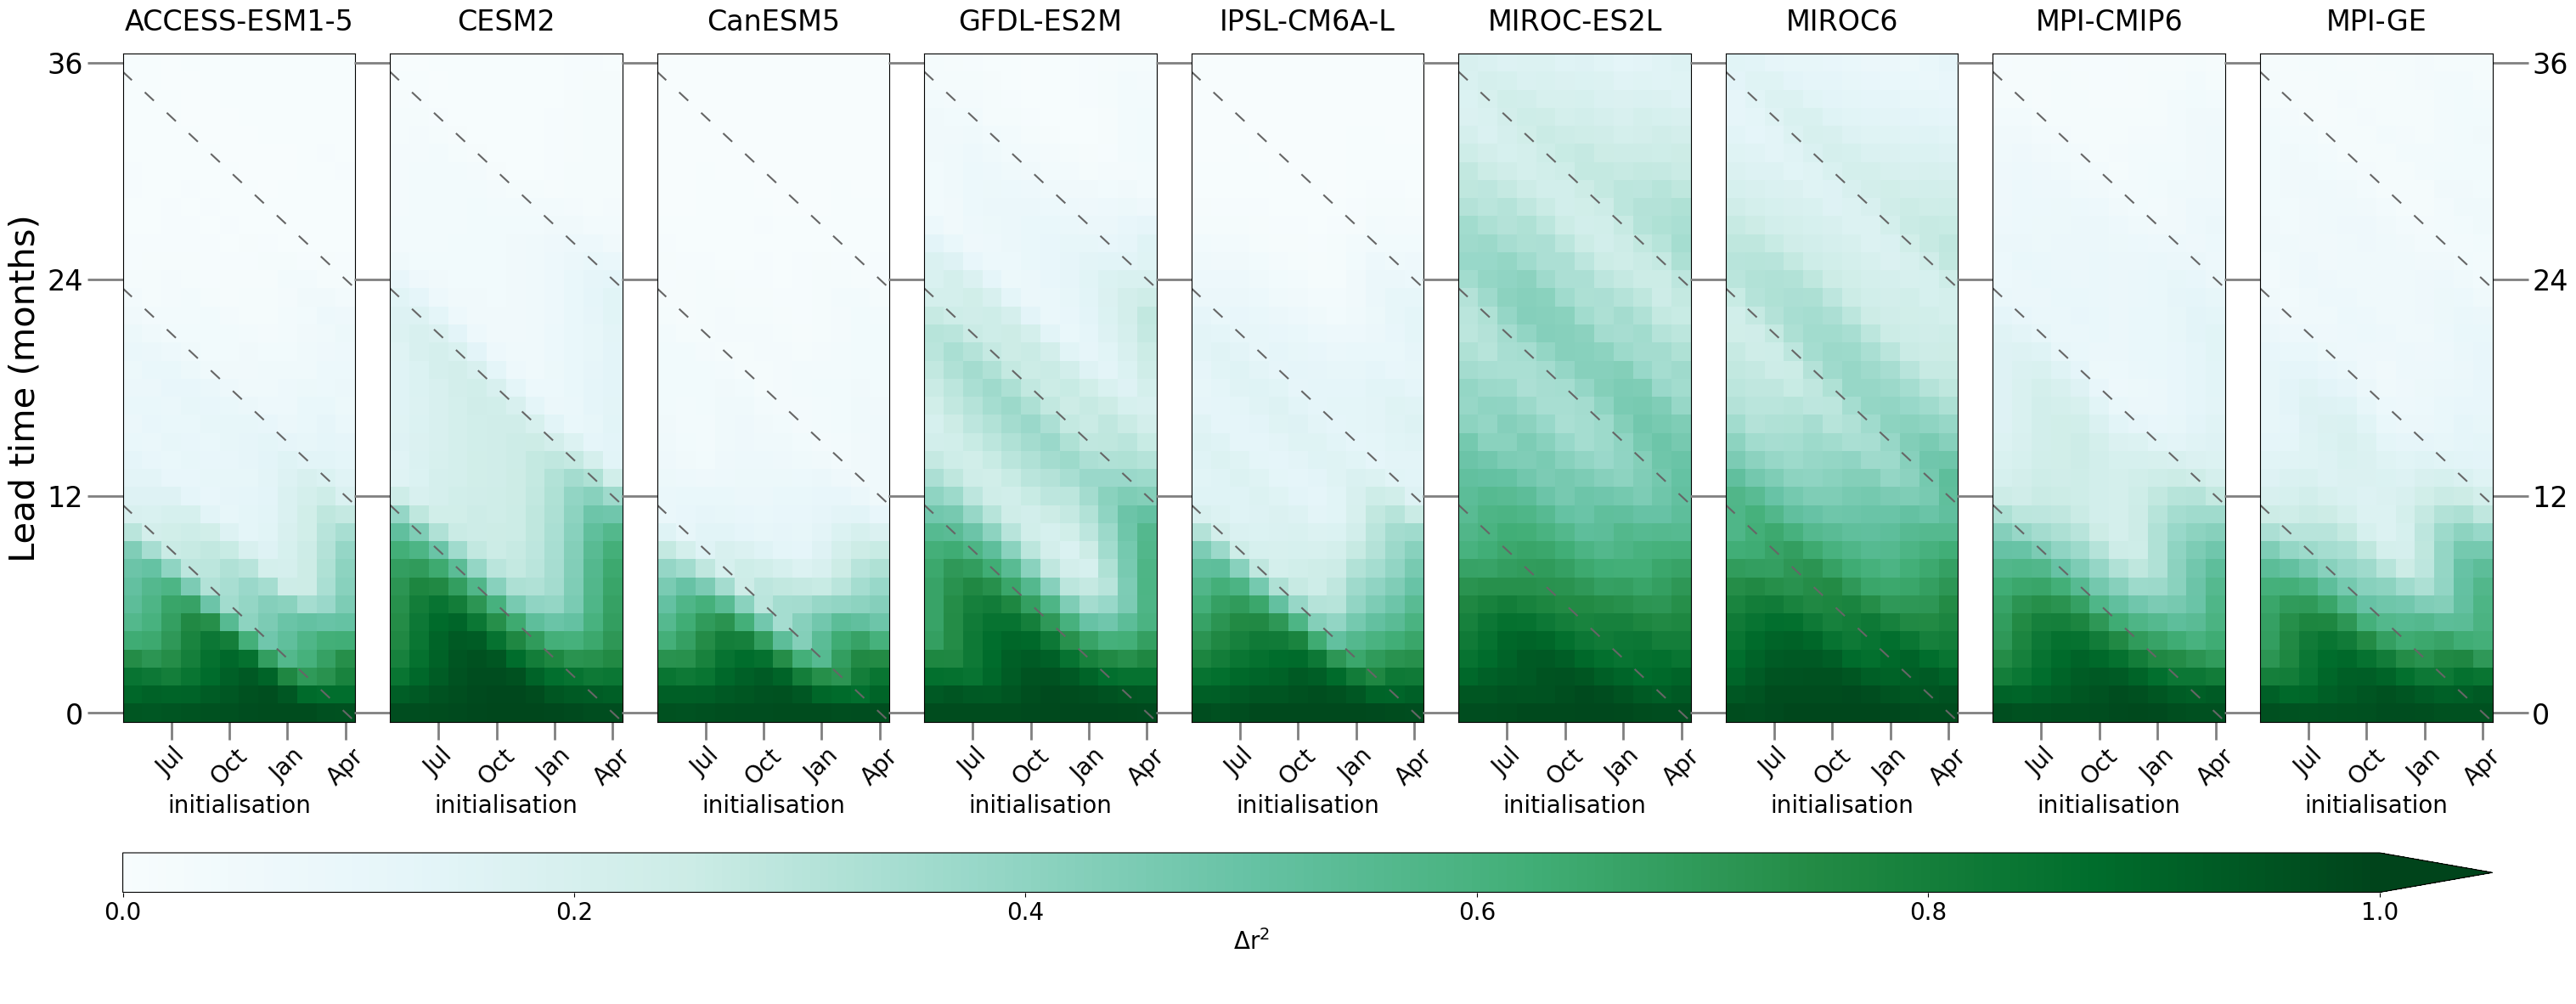

In [10]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','30P30A',)]).load()
plot_bunch_of_models(r,
                     start_mask = ('10P',),
                     later_mask = ('30P30A',),
                     skill_type='first_only',
                     vlim=(0,1),
                     models=models)
plt.subplots_adjust(hspace=0.35)


plt.savefig('figures/area_corr_weight/baseline.pdf',bbox_inches='tight',pad_inches=0.2)

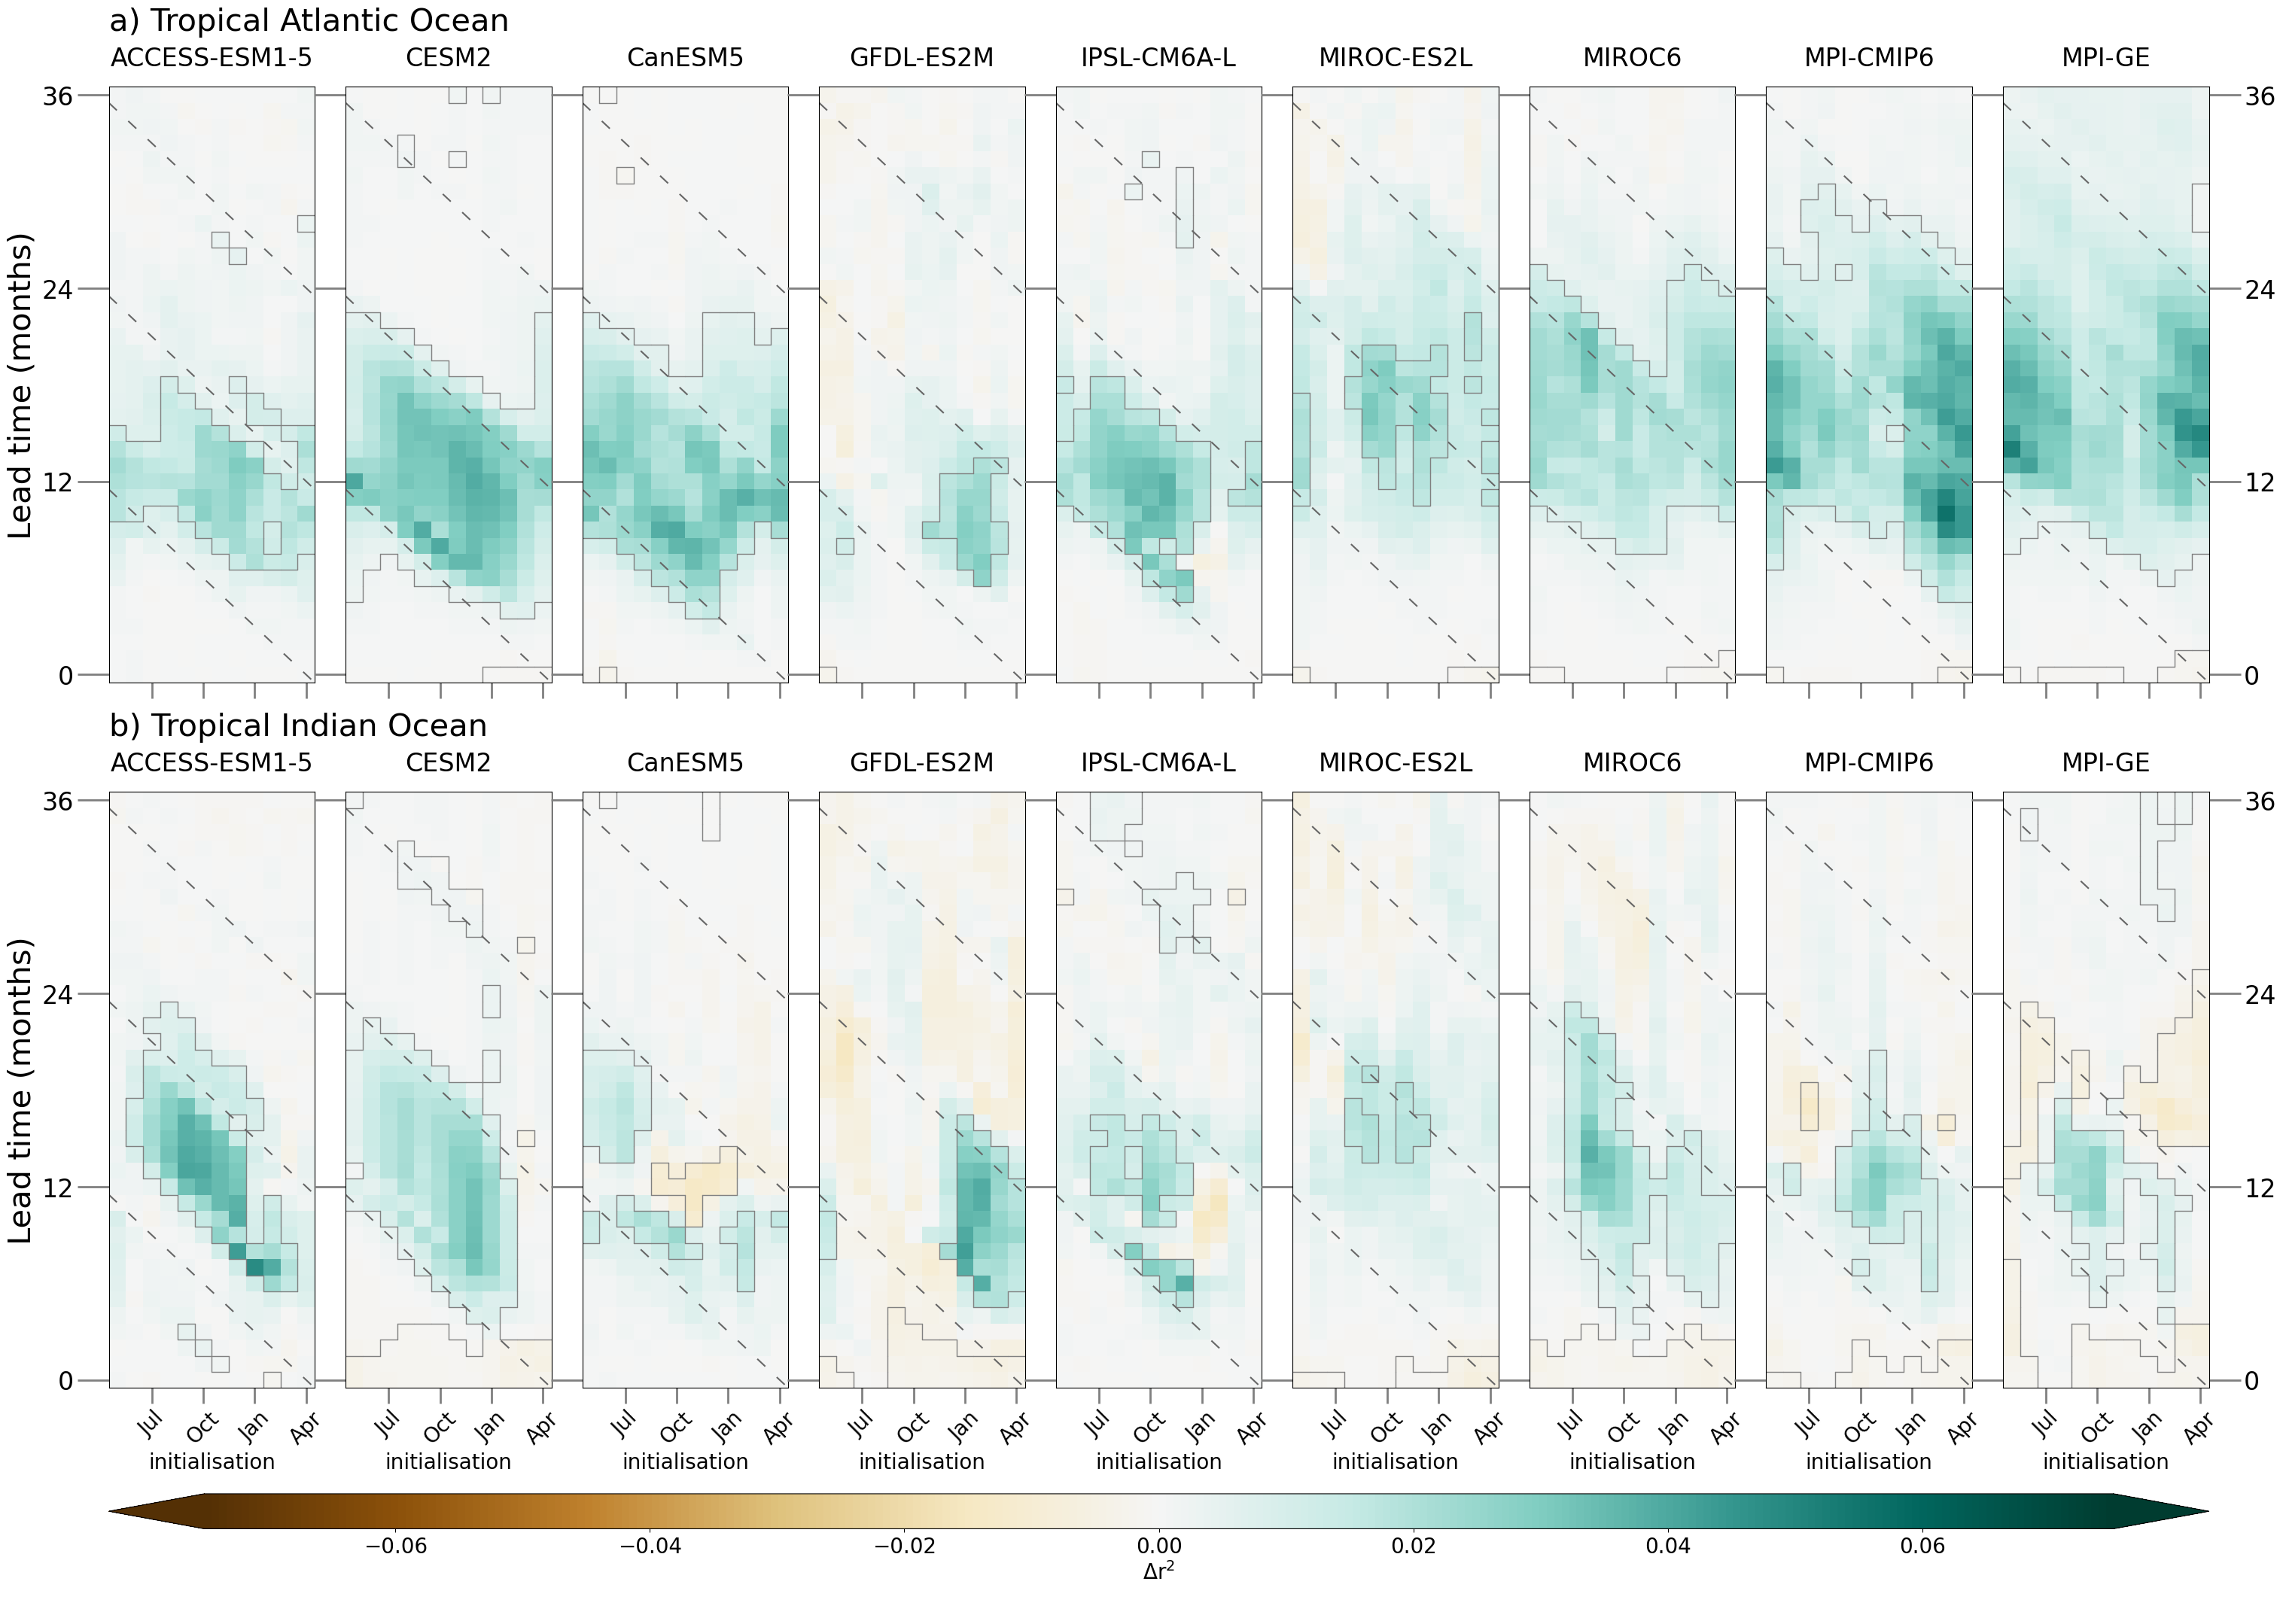

In [11]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10P30A','10P30I'),
                     models=models)
plt.subplots_adjust(hspace=0.25)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) Tropical Atlantic Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) Tropical Indian Ocean",size=30,ha='left',va='bottom')


plt.savefig('figures/area_corr_weight/10Ptropics.pdf')

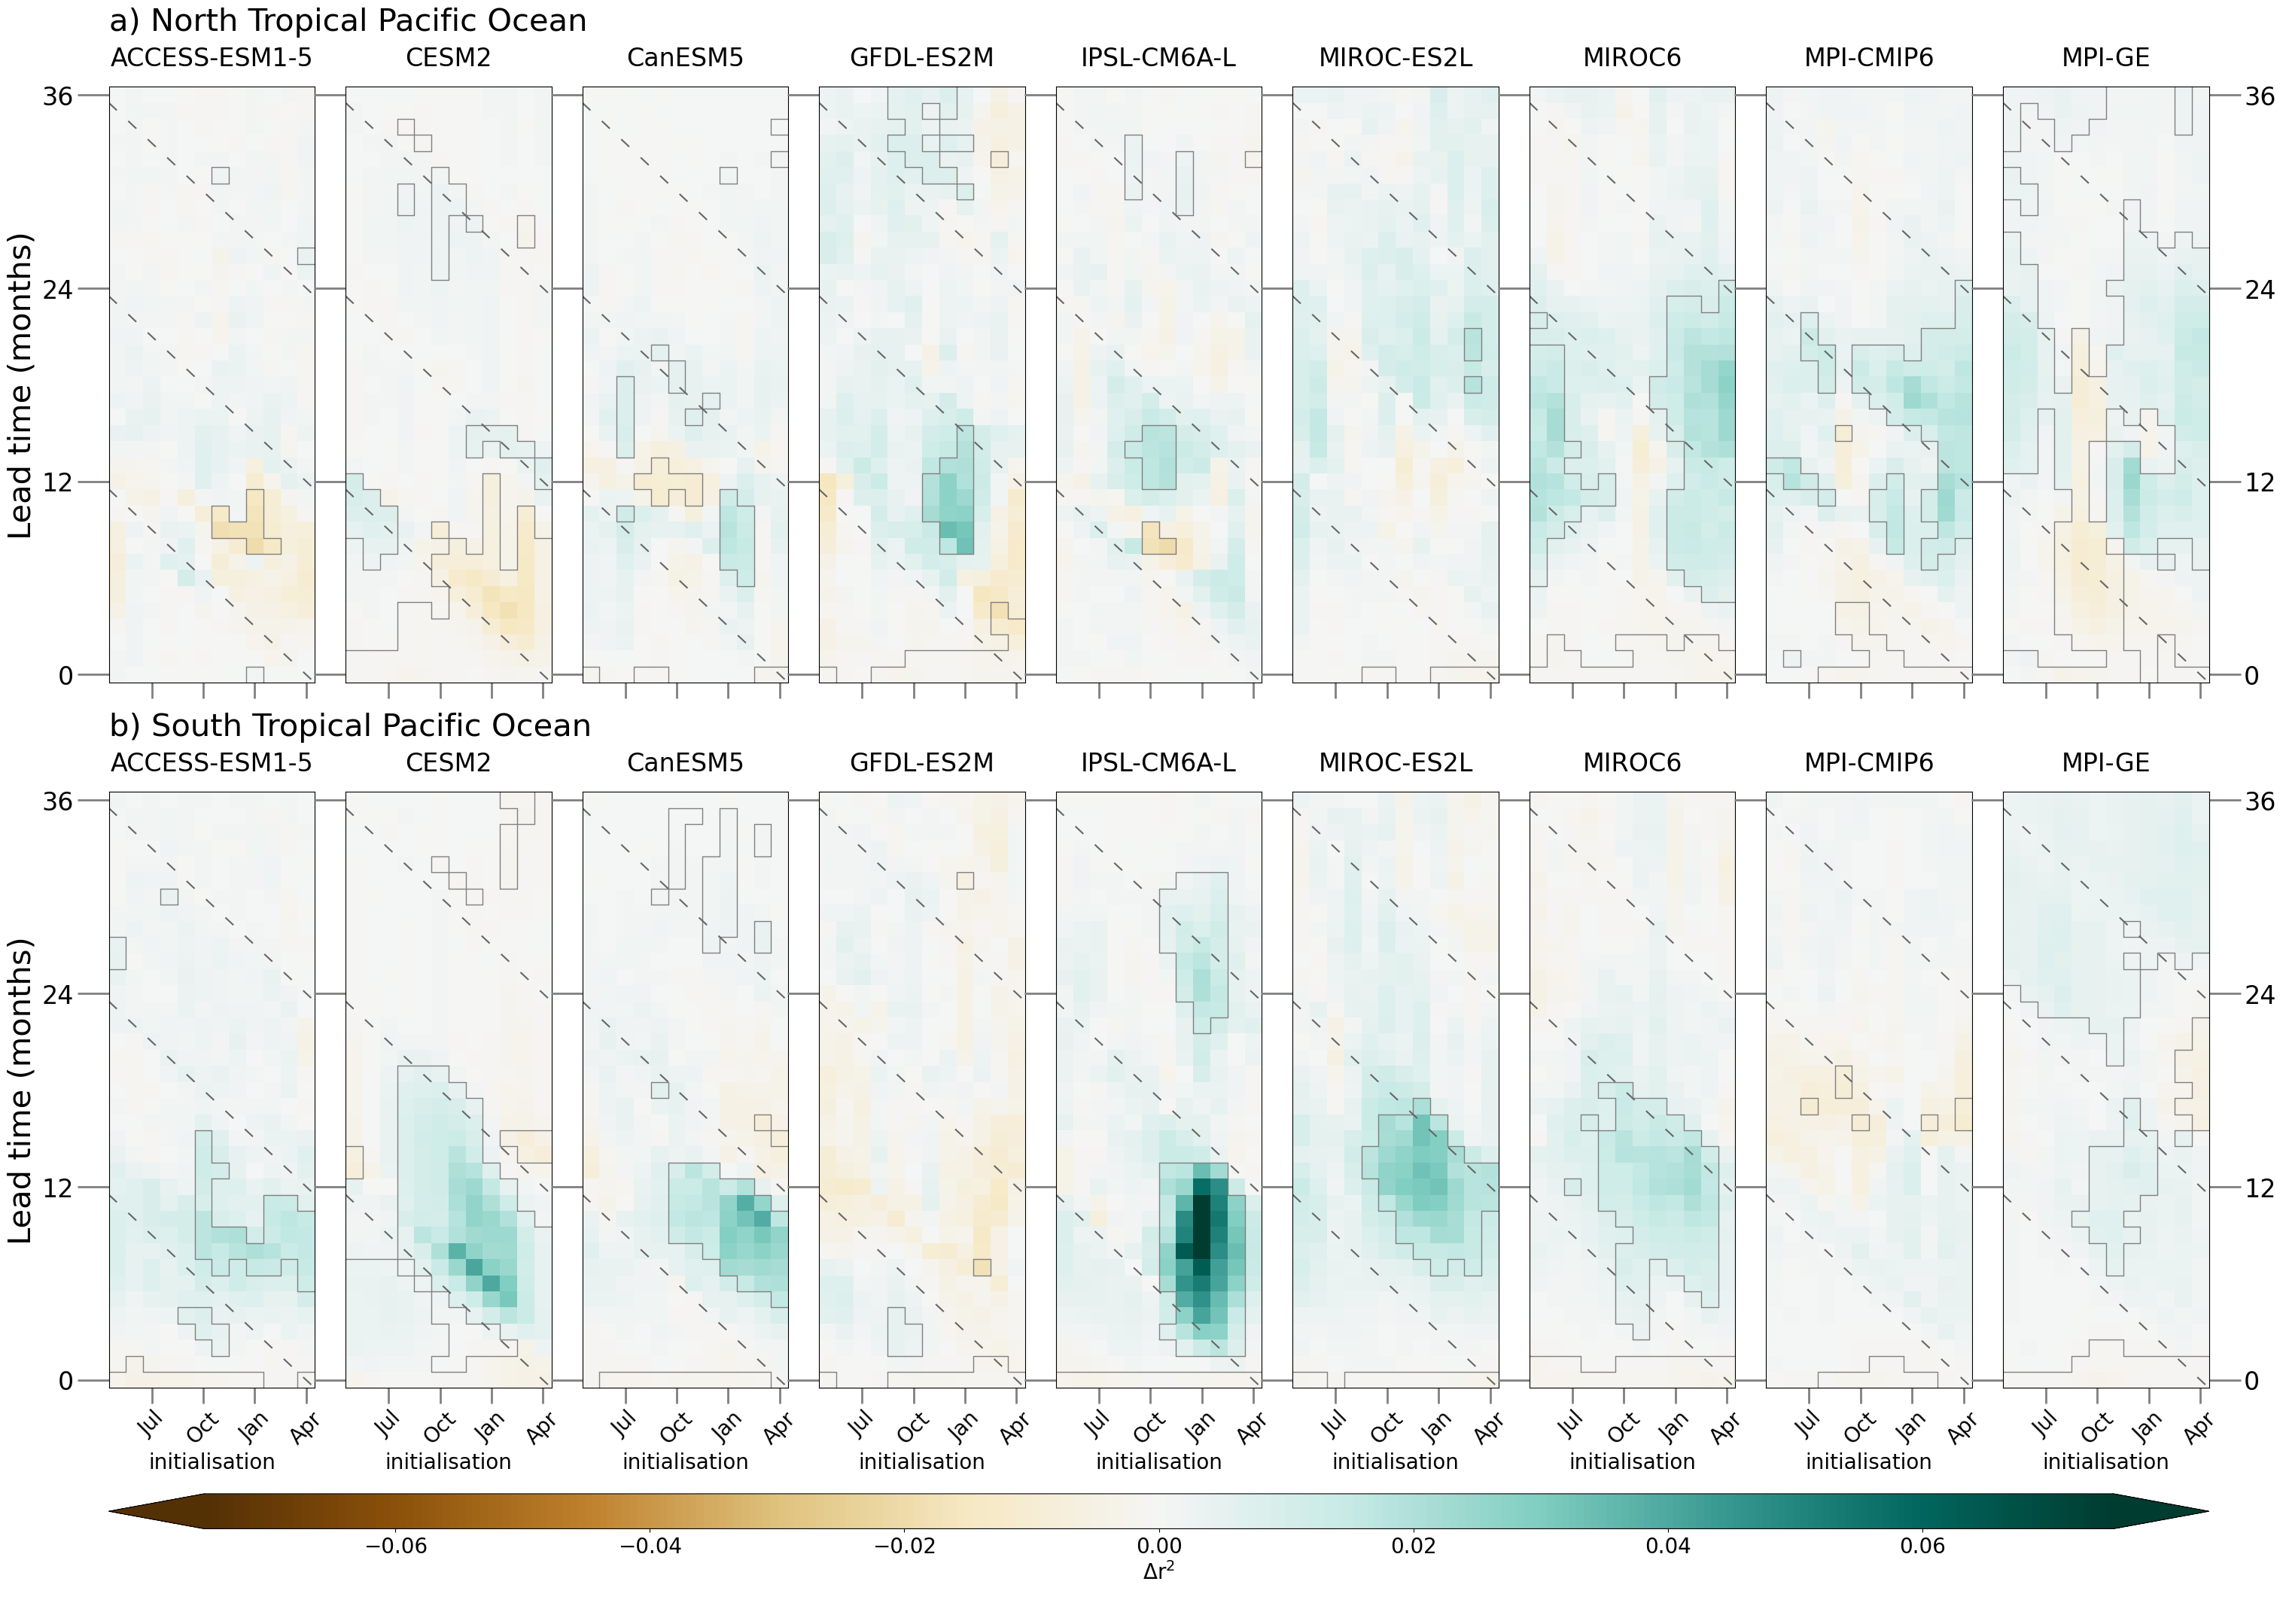

In [12]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10-30P','30-10P')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10-30P','30-10P'),
                     models=models)
plt.subplots_adjust(hspace=0.25)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) North Tropical Pacific Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) South Tropical Pacific Ocean",size=30,ha='left',va='bottom')


plt.savefig('figures/area_corr_weight/pacific.pdf')

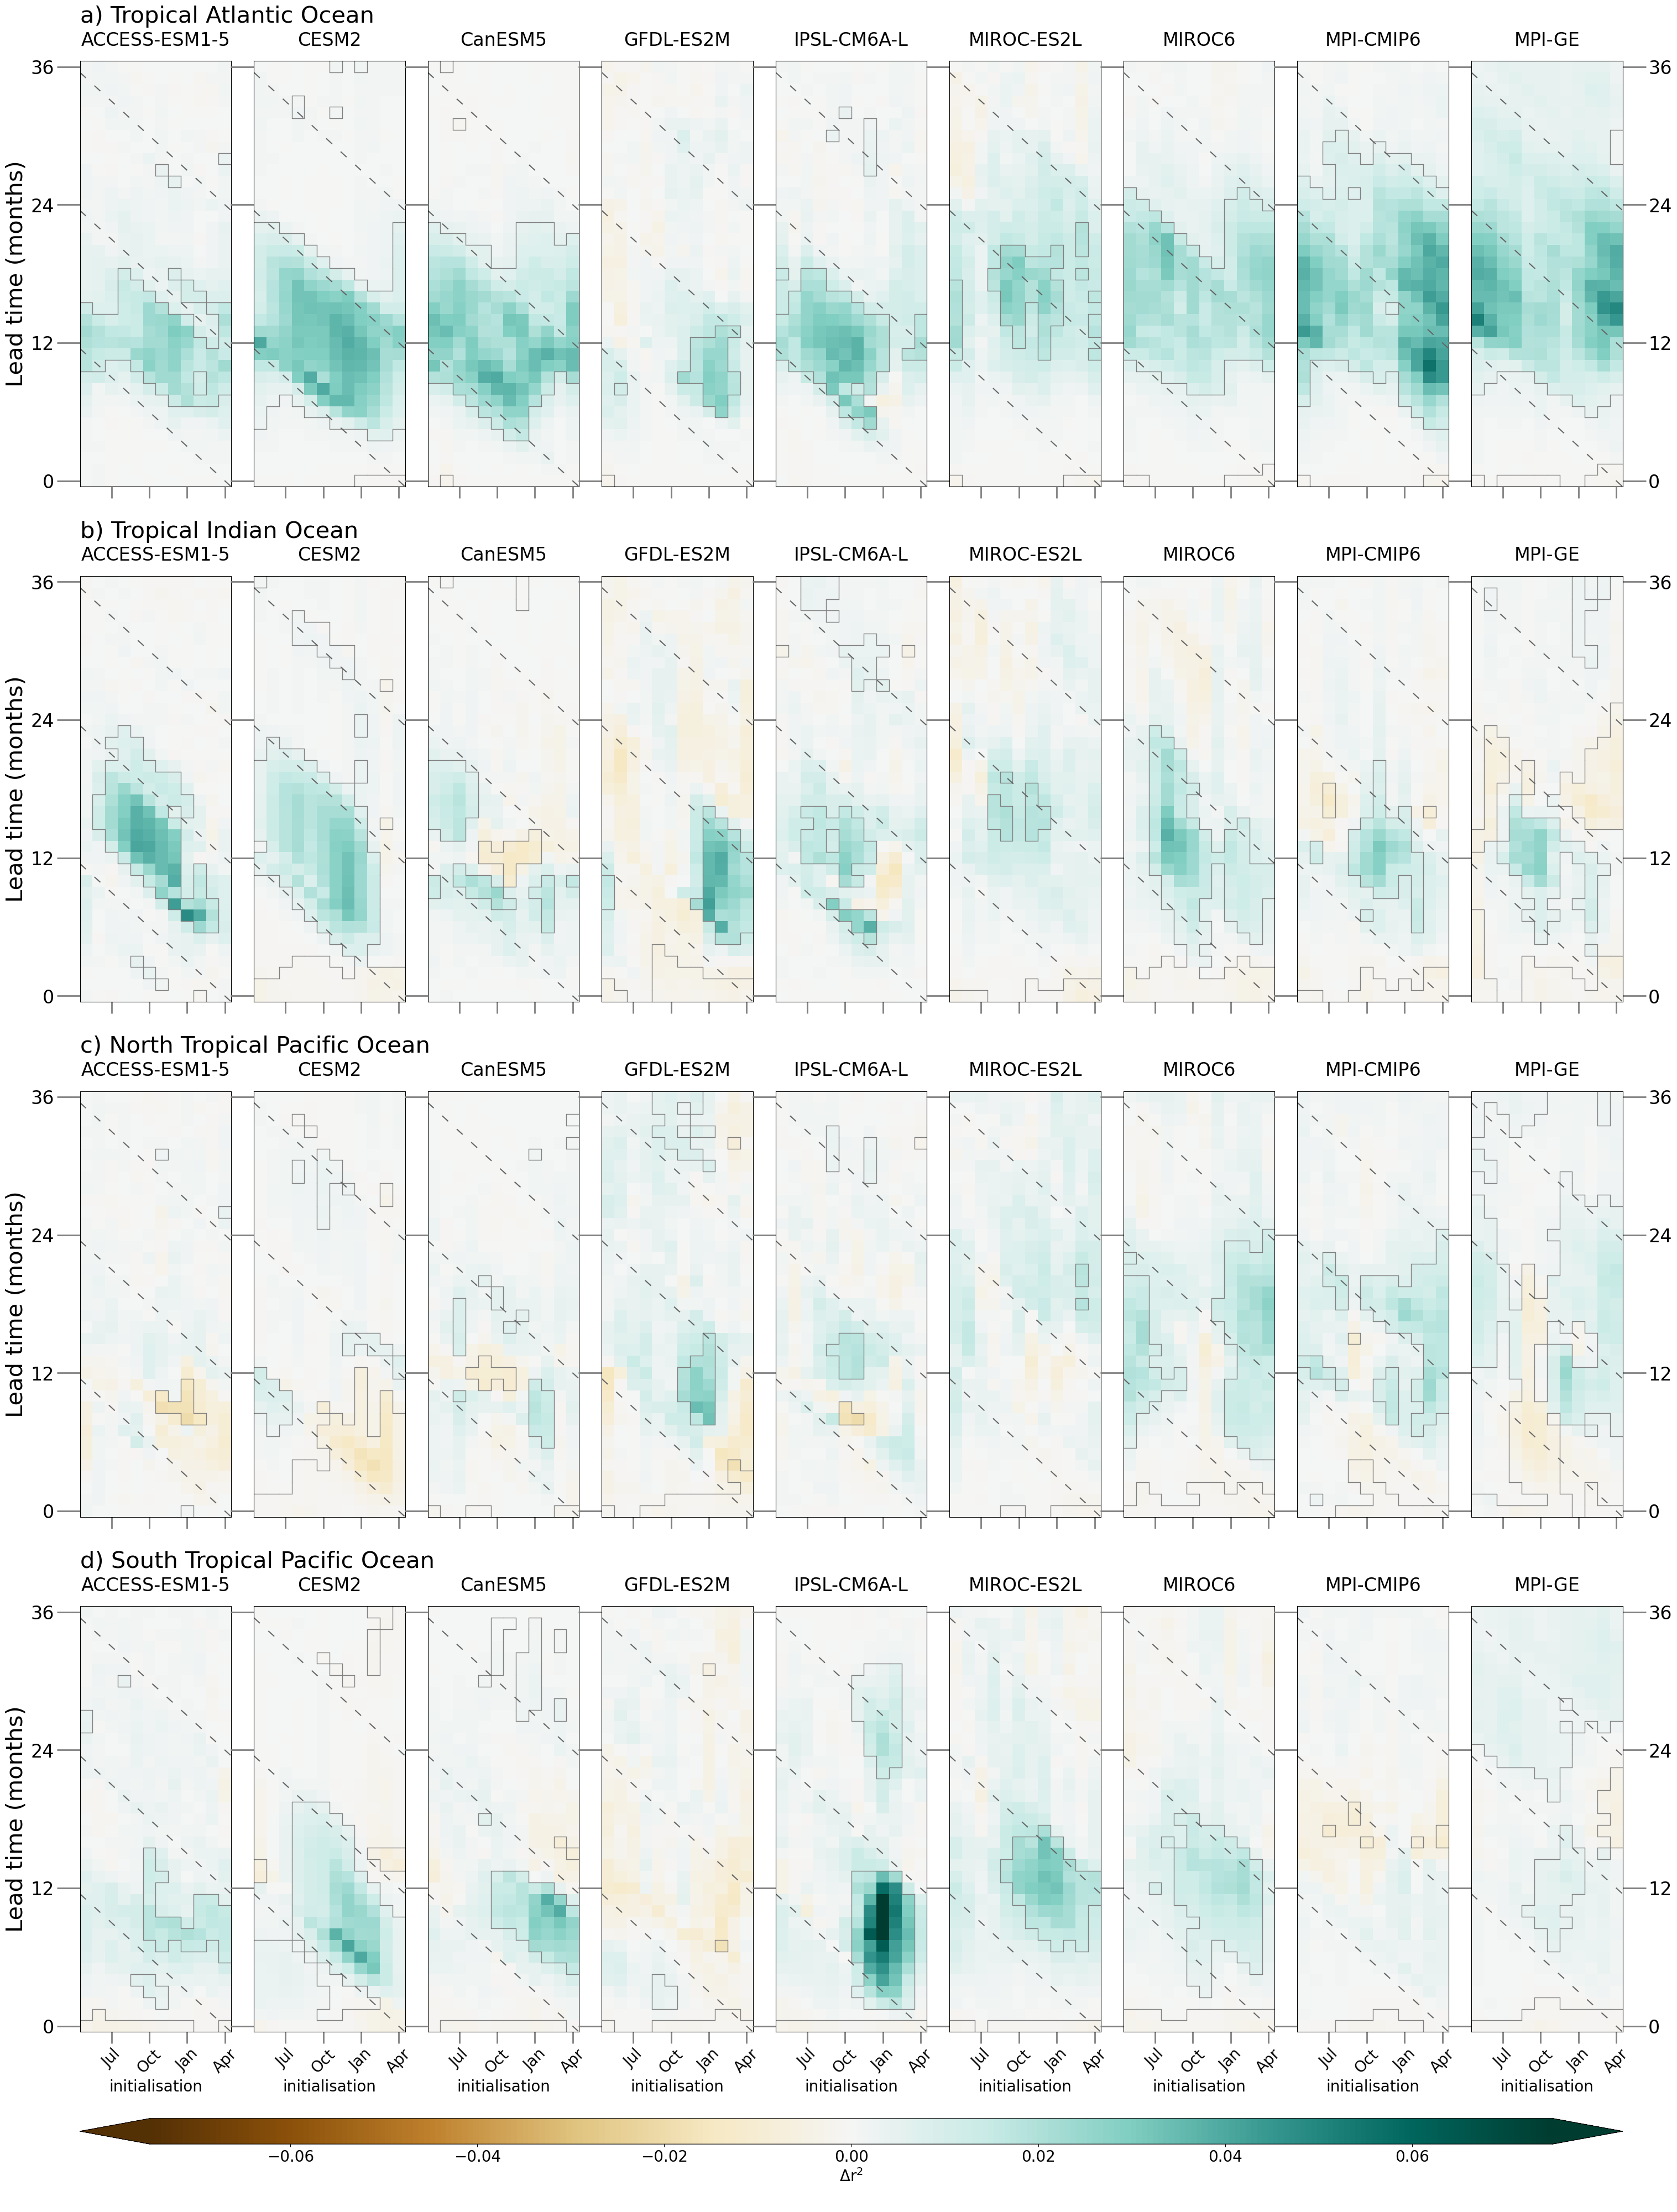

In [13]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A','10P30I','10-30P','30-10P')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P','10P','10P'),
                     later_mask = ('10P30A','10P30I','10-30P','30-10P'),
                     models=models)
plt.subplots_adjust(hspace=0.25)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.012,"a) Tropical Atlantic Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.012,"b) Tropical Indian Ocean",size=30,ha='left',va='bottom')
fig.text(axs[2,0].get_position().x0,axs[2,0].get_position().y1+0.012,"c) North Tropical Pacific Ocean",size=30,ha='left',va='bottom')
fig.text(axs[3,0].get_position().x0,axs[3,0].get_position().y1+0.012,"d) South Tropical Pacific Ocean",size=30,ha='left',va='bottom')

plt.savefig('figures/area_corr_weight/everything.pdf',bbox_inches='tight',pad_inches=0.4)

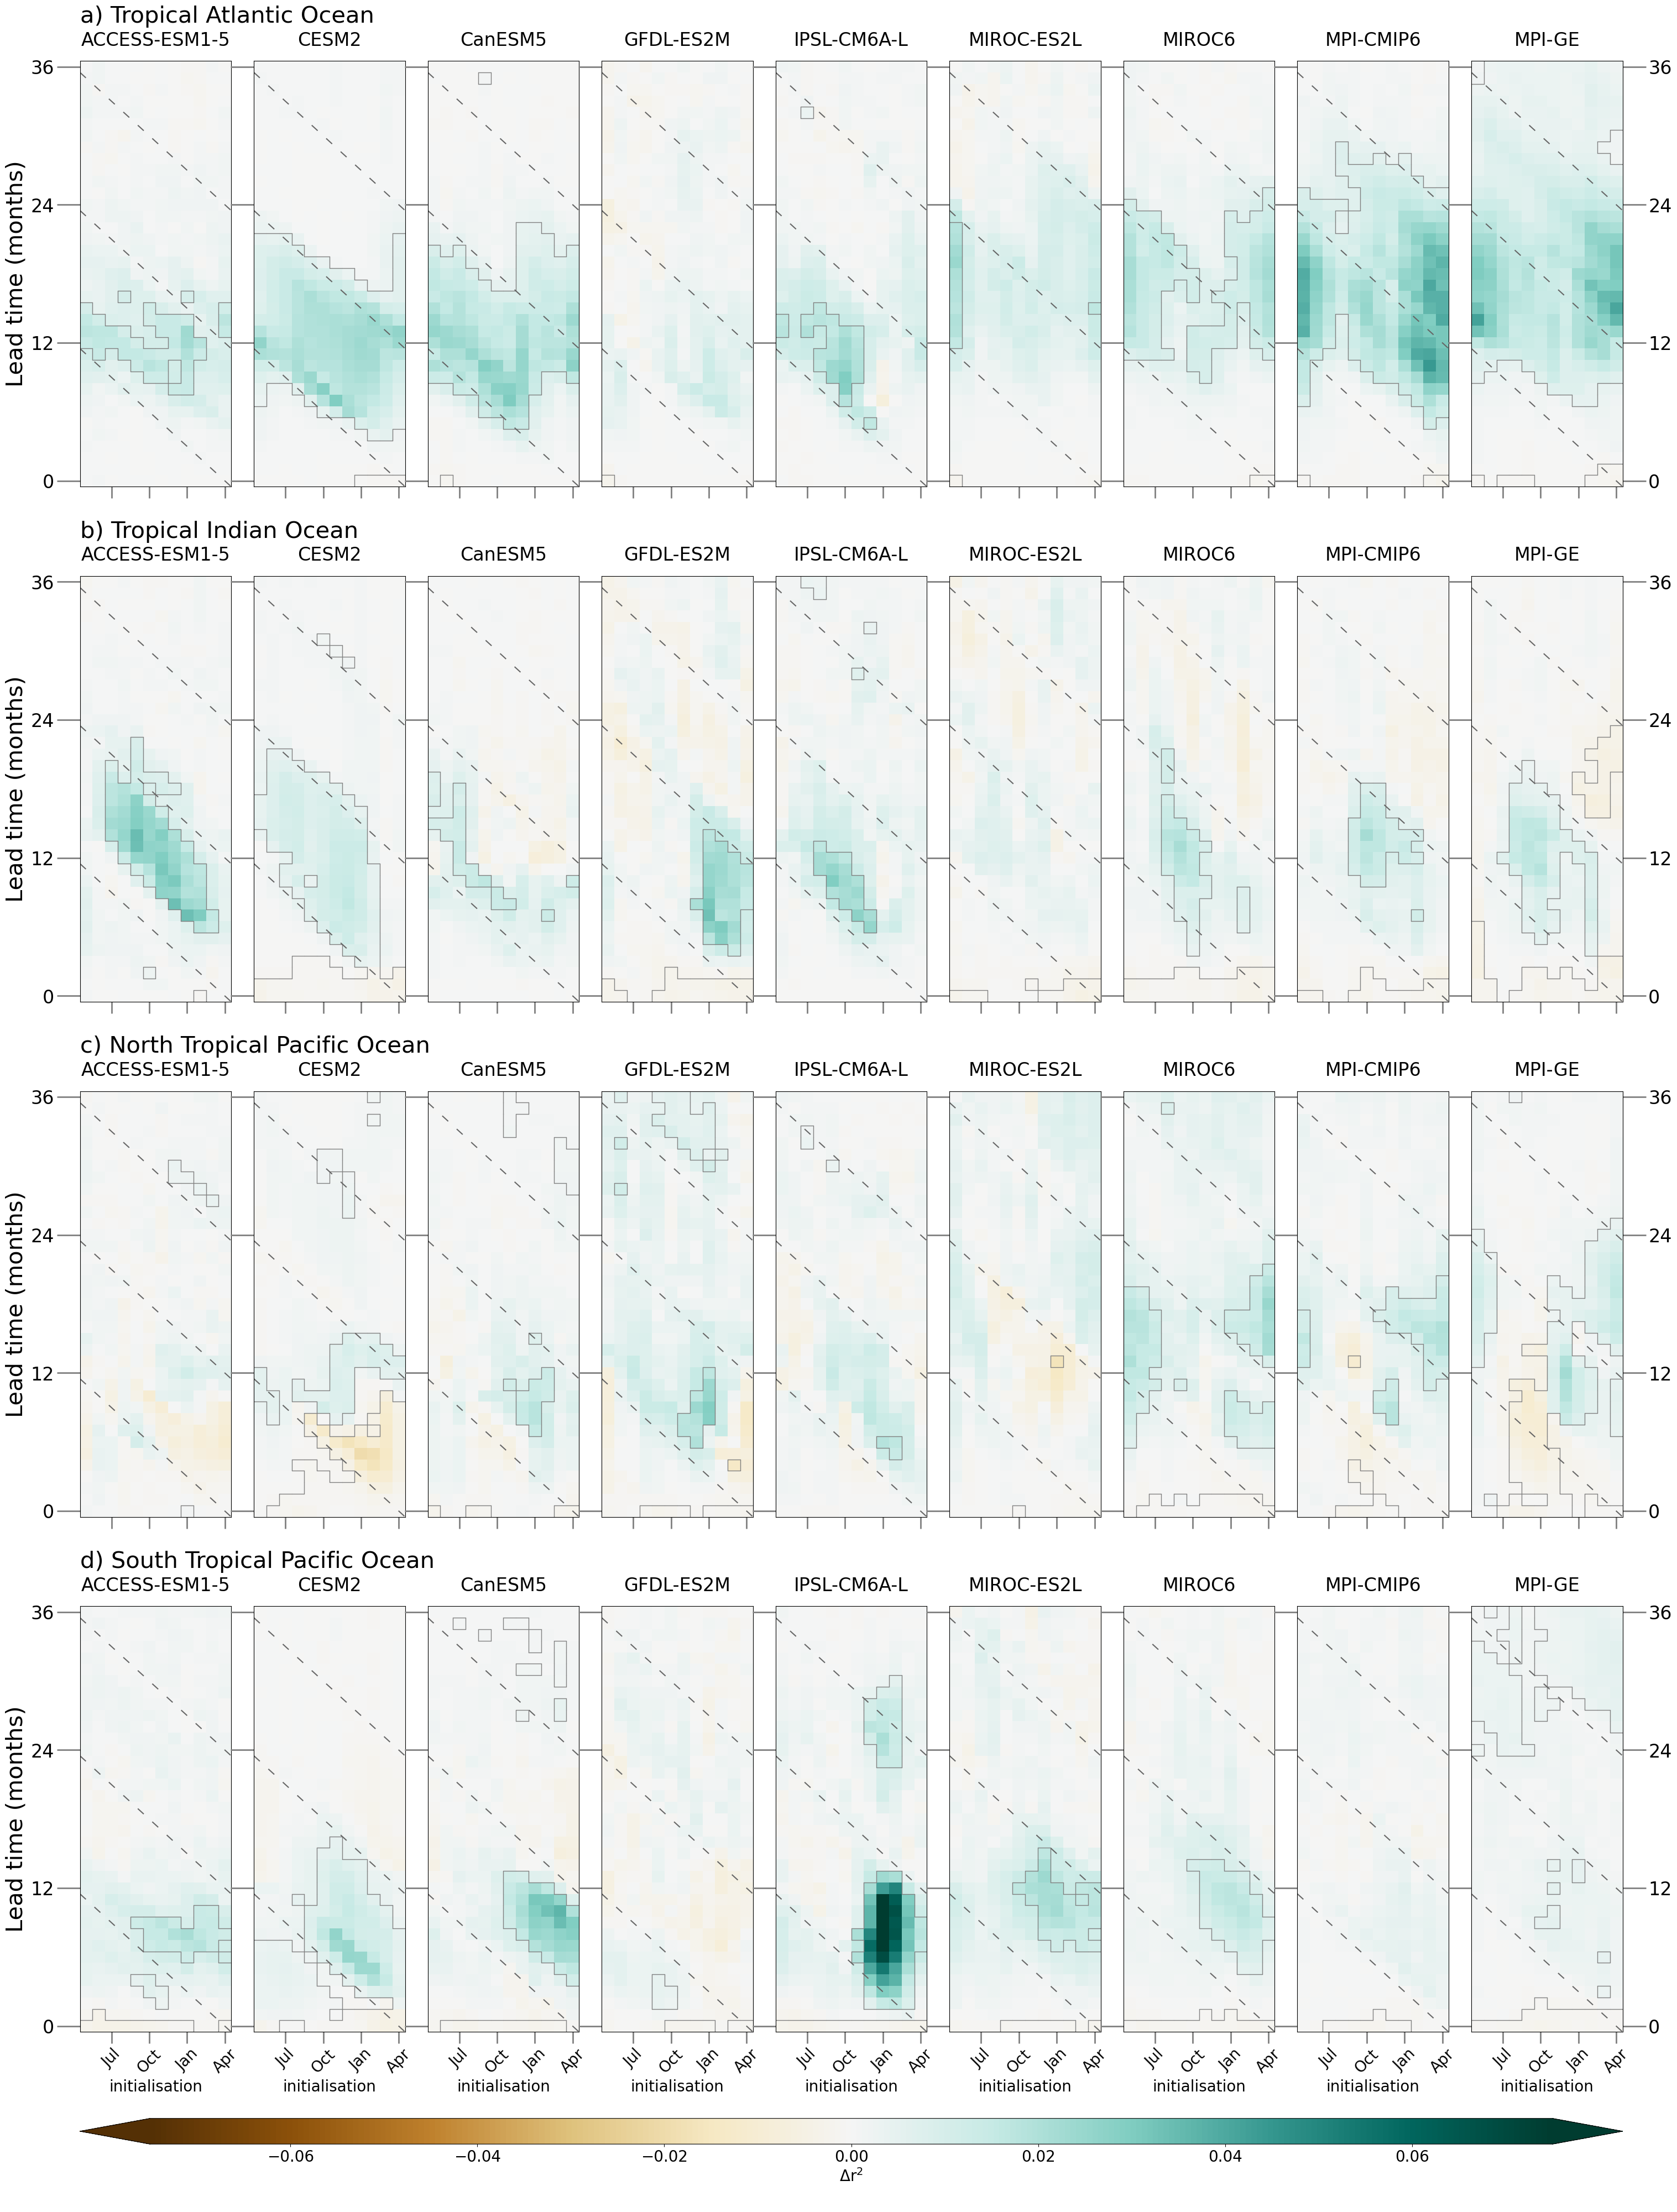

In [14]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('30P30A30I','30P30I','30P30A','30-10P30A30I','10-30P30A30I')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('30P30I','30P30A','30-10P30A30I','10-30P30A30I'),
                     later_mask = ('30P30A30I','30P30A30I','30P30A30I','30P30A30I'),
                     models=models)
plt.subplots_adjust(hspace=0.25)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.012,"a) Tropical Atlantic Ocean",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.012,"b) Tropical Indian Ocean",size=30,ha='left',va='bottom')
fig.text(axs[2,0].get_position().x0,axs[2,0].get_position().y1+0.012,"c) North Tropical Pacific Ocean",size=30,ha='left',va='bottom')
fig.text(axs[3,0].get_position().x0,axs[3,0].get_position().y1+0.012,"d) South Tropical Pacific Ocean",size=30,ha='left',va='bottom')


plt.savefig('figures/area_corr_weight/everything_inverse.pdf',bbox_inches='tight',pad_inches=0.4)

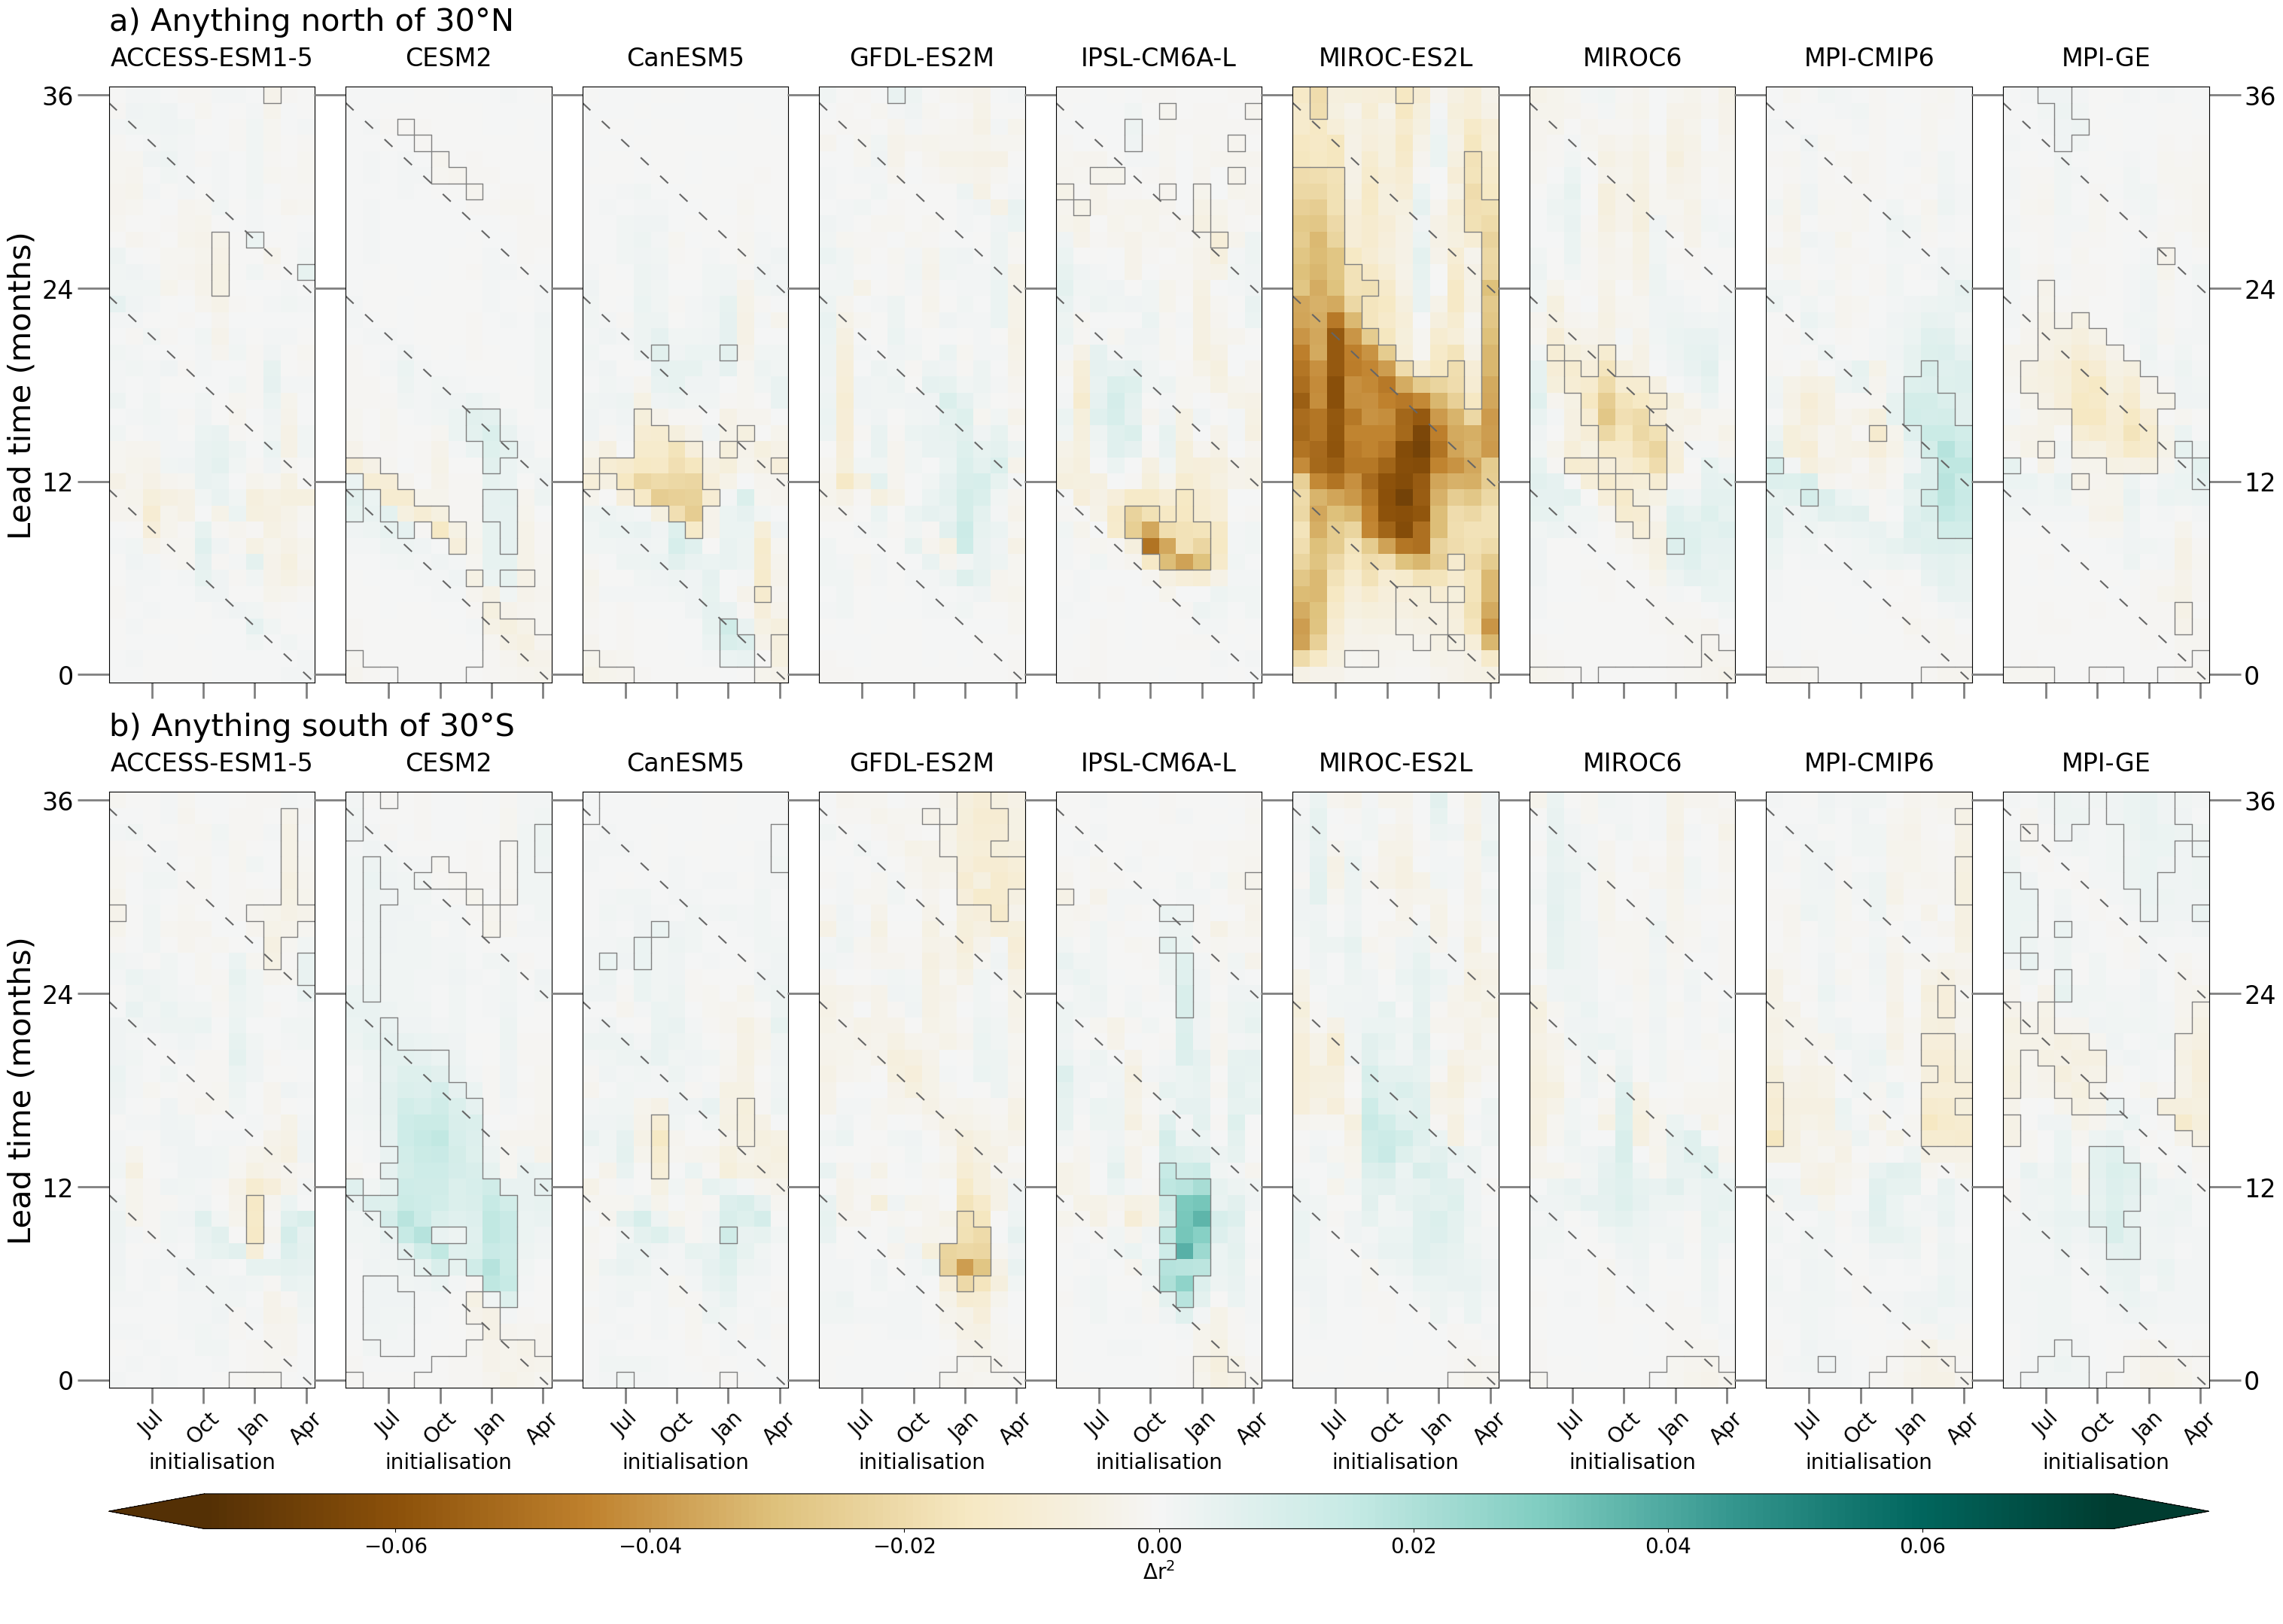

In [15]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('30P','60P','10P','10P30N','10P30S')]).load()
fig, axs = plot_bunch_of_models(r,
                     start_mask = ('10P','10P'),
                     later_mask = ('10P30N','10P30S'),
                     models=models)
plt.subplots_adjust(hspace=0.25)

fig.text(axs[0,0].get_position().x0,axs[0,0].get_position().y1+0.025,"a) Anything north of 30°N",size=30,ha='left',va='bottom')
fig.text(axs[1,0].get_position().x0,axs[1,0].get_position().y1+0.025,"b) Anything south of 30°S",size=30,ha='left',va='bottom')
plt.savefig('figures/area_corr_weight/poles.pdf',bbox_inches='tight',pad_inches=0.4)

In [6]:
def dictionary_mean(dict):
    mean = xr.zeros_like(dict[list(dict.keys())[0]])
    for k in dict:
        mean+=dict[k]
    mean/=len(dict.keys())
    return mean

In [7]:
def generate_linestyle_dicts():
    # Courtesy of ChatGPT, with modification
    c1 = np.array((132,25,90))/256
    c2 = np.array((0,150,255))/256
    
    colors = (c1,(c1+c2)/2,c2)
    # Define the line styles you want
    linestyles = ['-', '--', ':']  # Continuous, dashed, and dotted
    
    # Generate the combinations of colors and line styles
    linestyle_dicts = []
    for i, color in enumerate(colors):
        for j, style in enumerate(linestyles):
            linestyle_dicts.append({'c': color, 'linestyle': style})
    
    return linestyle_dicts
generate_linestyle_dicts()

[{'c': array([0.515625  , 0.09765625, 0.3515625 ]), 'linestyle': '-'},
 {'c': array([0.515625  , 0.09765625, 0.3515625 ]), 'linestyle': '--'},
 {'c': array([0.515625  , 0.09765625, 0.3515625 ]), 'linestyle': ':'},
 {'c': array([0.2578125 , 0.34179688, 0.67382812]), 'linestyle': '-'},
 {'c': array([0.2578125 , 0.34179688, 0.67382812]), 'linestyle': '--'},
 {'c': array([0.2578125 , 0.34179688, 0.67382812]), 'linestyle': ':'},
 {'c': array([0.        , 0.5859375 , 0.99609375]), 'linestyle': '-'},
 {'c': array([0.        , 0.5859375 , 0.99609375]), 'linestyle': '--'},
 {'c': array([0.        , 0.5859375 , 0.99609375]), 'linestyle': ':'}]

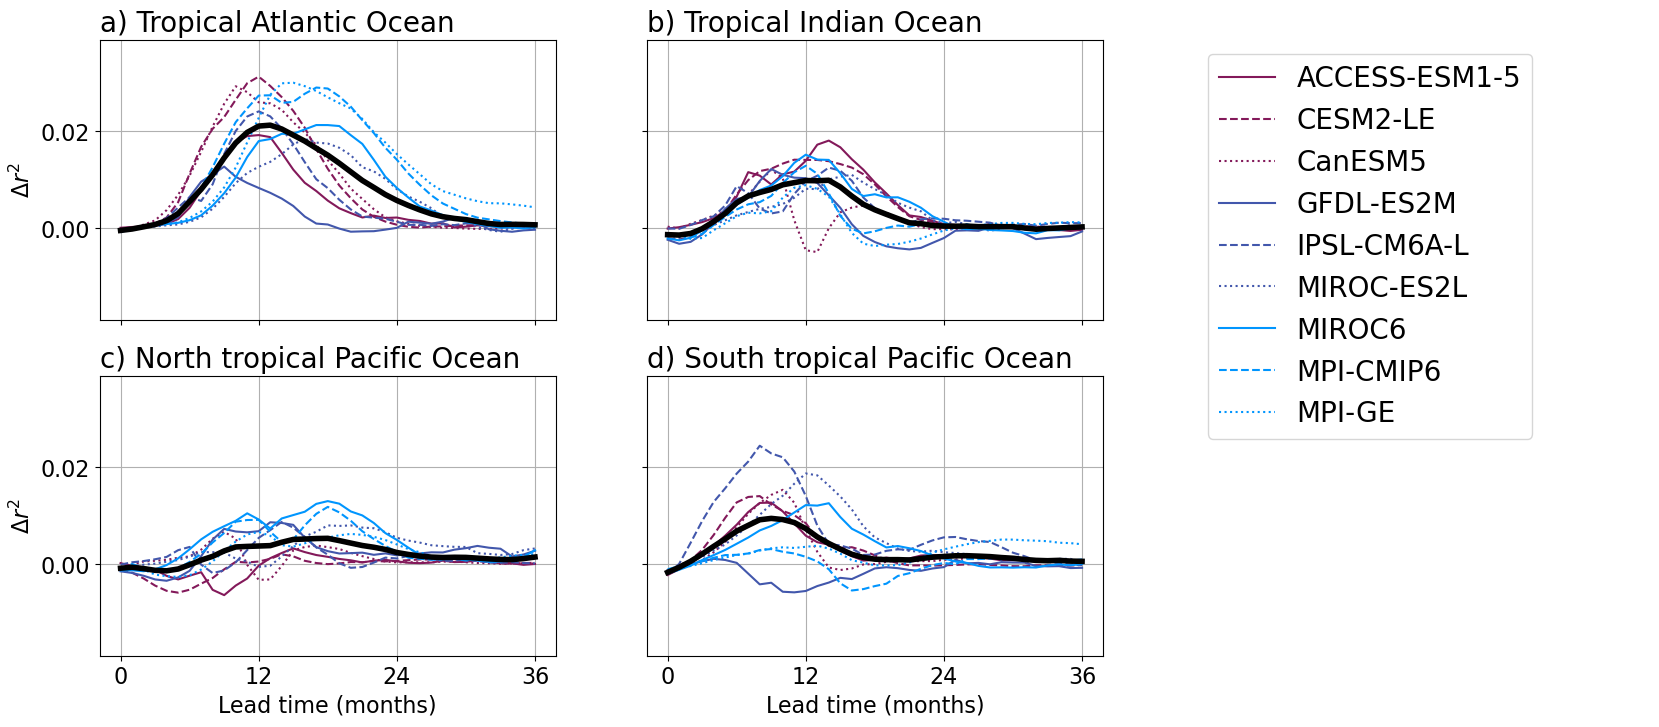

In [12]:
## Let's draw some boring line sailboats

plt.rcParams['font.size'] = 16
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','30P','10P30A','10P30I','30-10P','10-30P')]).load()

fig, axs = plt.subplots(2,3,figsize=(10*2,4*2),sharex=True, sharey = True)

start_mask = ('10P','10P','10P','10P')
end_mask=('10P30A','10P30I','10-30P','30-10P')
titles = ('a) Tropical Atlantic Ocean','b) Tropical Indian Ocean','c) North tropical Pacific Ocean','d) South tropical Pacific Ocean')
axesss = (axs[0,0],axs[0,1],axs[1,0],axs[1,1])
linestyles = generate_linestyle_dicts()
for i in range(4):
    plt.sca(axesss[i])
    legend = []
    legend_k = []
    for mi,k in enumerate(r.keys()):
        legend.append(plt.plot((r[k].sel(mask=end_mask[i])**2-r[k].sel(mask=start_mask[i])**2).mean('init_month'),**linestyles[mi])[0])
        legend_k.append(k)
    plt.plot(dictionary_mean((r.sel(mask=end_mask[i])**2-r.sel(mask=start_mask[i])**2).mean('init_month')),c='k',linewidth=4)
    plt.ylim(-0.019,0.039)
    plt.xticks((0,12,24,36))
    plt.grid()
    plt.title(titles[i],loc='left',fontsize=20)
plt.sca(axs[0,2])
plt.axis('off')
plt.legend(legend,legend_k,loc='upper left',fontsize=20)
plt.sca(axs[1,2])
plt.axis('off')

axs[0,0].set_ylabel('$\\Delta r^2$')
axs[1,0].set_ylabel('$\\Delta r^2$')
axs[1,0].set_xlabel('Lead time (months)')
axs[1,1].set_xlabel('Lead time (months)')
plt.savefig('figures/area_corr_weight/annual_mean.pdf',bbox_inches='tight')

plt.rcParams['font.size'] = 24

In [3]:
r = xr.open_mfdataset(['/glade/work/jjeffree/results/area_corr/multiindex/NINO34_r/'+m+'.nc' 
                       for m in ('10P','10P30A')]).load()

In [4]:
peak = ((r.sel(mask='10P30A')**2-r.sel(mask='10P')**2)).mean('init_month').argmax('L')

In [9]:
lag = []
for i in range(len(models)):
    model_name = models[i]
    nino34 = xr.load_dataarray('/glade/derecho/scratch/jjeffree/240723_indices_dump/'+model_name+'_nomean_nino34.nc')
    lag.append(find_peak_lag(nino34))
    del nino34

In [8]:
def find_peak_lag(x):
    autocorr = [xr.corr(x,x.shift({'time':l}),('time','SMILE_M')) for l in range(36)]
    return np.argmin(autocorr)

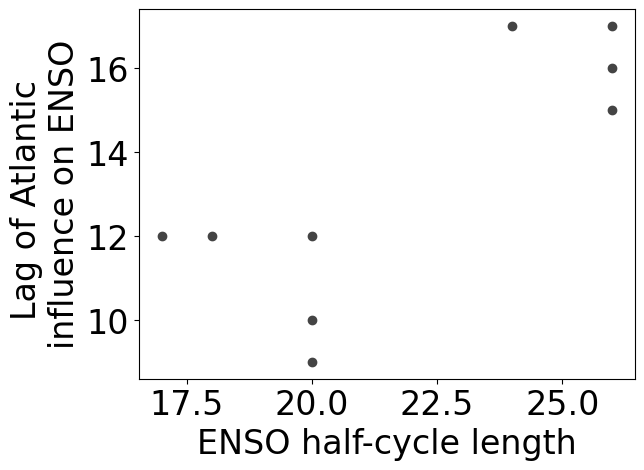

In [17]:
plt.scatter(lag,[peak[k] for k in peak.keys()],c='#444444')
plt.ylabel('Lag of Atlantic \ninfluence on ENSO')
plt.xlabel('ENSO half-cycle length')
plt.savefig('figures/area_corr_weight/useless_scatter_plot.pdf',bbox_inches='tight',pad_inches=0.4)

In [17]:
np.corrcoef(lag,[peak[k] for k in peak.keys()])

array([[1.        , 0.79783134],
       [0.79783134, 1.        ]])